<a href="https://colab.research.google.com/github/archyyu/GPT-from-MLP-to-RNN-to-Transformer/blob/main/GPT_by_Deep_RNN_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# Data I/O

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
#url = "https://raw.githubusercontent.com/archyyu/publicResource/main/google.dev.en"
#url = "https://raw.githubusercontent.com/torvalds/linux/master/mm/madvise.c"
response = requests.get(url)
data = response.text

n = int(0.9*len(data))
training_data = data[:n]
val_data = data[n:]

chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


In [3]:
# Hyperparameters
hidden_size = 100
embedding_dim = 40
seq_length = 30
learning_rate = 1e-1
batch_size = 20
deep_num = 3
dropout_prob = 0.1
eval_iters = 200


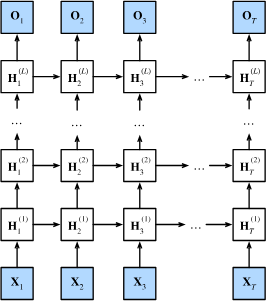

as illustrated by the above graph.
we could define the layers of the rnn as deep_num
and every hidden state is decided by the pre step hidden state and the lower layers hidden state.

let us implement this structure.

from what I understand, If the RNN is deep, let say 3 layers, then the performance of the model should be better?

but the result is a little disappointing. dont know why

So I update the deepRNN again.

Let see the result

In [ ]:
# We should change the VanillaRNN a little bit, so could be used in deep RNN.
class SimpleRNN(nn.Module):
  def __init__(self, hidden_size):
    super(SimpleRNN, self).__init__()
    self.i2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)
    self.ob = nn.Parameter(torch.zeros(1, hidden_size))
    # self.layer_norm = nn.LayerNorm(hidden_size)

  def forward(self, pre_h_list):
    h_list = []
    for i in range(pre_h_list.size(1)):
      if i == 0:
        h = torch.tanh(self.i2h(pre_h_list[:, i, :]) + self.ob)
      else:
        h = torch.tanh(self.i2h(pre_h_list[:, i, :]) + self.h2h(h) + self.ob)
      h_list.append(h)

    return torch.stack(h_list, dim=1)


class DeepRNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRNN, self).__init__()
    self.deep_num = deep_num
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.e2h = nn.Linear(embedding_dim, hidden_size, bias=False)
    self.rnn_list = nn.ModuleList([SimpleRNN(hidden_size) for _ in range(deep_num)])
    self.h2o = nn.Linear(hidden_size, vocab_size, bias=False)
    self.ob = nn.Parameter(torch.zeros(1, vocab_size))

  def forward(self, x, targets):
    x = self.embedding(x)
    B,T,C = x.shape
    h = self.e2h(x)
    for i in range(self.deep_num):
      h = self.rnn_list[i](h)
    y = self.h2o(h) + self.ob
    if targets is None:
      loss = None
    else:
      B,T = targets.shape
      loss = F.cross_entropy(y.view(B*T, -1), targets.view(B*T))
    return y, loss

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRNN(vocab_size, embedding_dim, hidden_size, deep_num)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

the above DeepRNN is writen from scrach
the following DeepRNN is using pytorch.rnn
let us compare those two models, to see which is better.

In [35]:
class DeepRnn(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_size, deep_num):
    super(DeepRnn, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.deep_num = deep_num
    self.deep_rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=deep_num, batch_first=True)
    self.h2o = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x, targets):
    x = self.embedding(x)
    B,T,C = x.shape
    hidden_state = torch.zeros(self.deep_num, B, hidden_size)
    y, hidden_state = self.deep_rnn(x, hidden_state)
    y = self.h2o(y)
    if targets is None:
      loss = None
    else:
      loss = F.cross_entropy(y.reshape(B*T, -1), targets.view(B*T))
    return y, loss

# Loss function
criterion = nn.CrossEntropyLoss()

# Model initialization
model = DeepRnn(vocab_size, embedding_dim, hidden_size, deep_num)
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

I updated the VanillaRNN a little, since We dont need the output of the intermediate node in Deep RNN, so we could remove the self.h2o linear layer. and add an final linear layer in the upper layer, by doing so, we could significantly reduce the amount of the parameters in the nn.

In [12]:
def get_batch(split):
  batch_inputs = []
  batch_targets = []

  data = training_data
  if split == "val":
    data = val_data

  start_idx = torch.randint(len(data) - batch_size - seq_length - 2,[1]).item()
  for i in range(batch_size):
    p = start_idx + i
    inputs = torch.tensor([char_to_ix[ch] for ch in data[p:p + seq_length]], dtype=torch.long).view(1, -1)
    targets = torch.tensor([char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]], dtype=torch.long).view(-1)

    batch_inputs.append(inputs)
    batch_targets.append(targets)

  # Convert lists to tensors
  minibatch_inputs = torch.cat(batch_inputs, dim=0)
  minibatch_targets = torch.stack(batch_targets)
  return minibatch_inputs, minibatch_targets


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [40]:
# Training loop
num_iterations = 10000
for iteration in range(num_iterations):

  inputs, targets = get_batch('train')

  predict_char, loss = model(inputs, targets)

  optimizer.zero_grad(set_to_none=True)
  B,T = targets.shape

  loss = criterion(predict_char.reshape(B*T, -1), targets.view(B*T))

  loss.backward()

  for param in model.parameters():
    if param.grad is not None:
      param.grad.data.clamp_(-5, 5)

  optimizer.step()
  if iteration % 1000 == 0:
    losses = estimate_loss()
    print(f"step {iteration}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")


step 0: train loss 1.9753, val loss 2.0653
step 1000: train loss 1.9504, val loss 2.0511
step 2000: train loss 1.9305, val loss 2.0315
step 3000: train loss 1.9052, val loss 1.9991
step 4000: train loss 1.9313, val loss 2.0132
step 5000: train loss 1.9188, val loss 1.9987
step 6000: train loss 1.8957, val loss 1.9998
step 7000: train loss 1.8525, val loss 1.9648
step 8000: train loss 1.8692, val loss 1.9443
step 9000: train loss 1.8563, val loss 1.9670


In [41]:
with torch.no_grad():
  # Sample from the model
  x = torch.tensor(char_to_ix[data[0]], dtype=torch.long).view(1, 1)
  ixes = []
  ixes.append(ix_to_char[x[0][0].item()])

  n = 2000

  for _ in range(n):
    inputs = torch.tensor([char_to_ix[ch] for ch in ixes[-seq_length * 2:]], dtype=torch.long).view(1, -1)
    outputs,_ = model(inputs, None)
    outputs = outputs[:,-1,:]
    p = nn.functional.softmax(outputs, dim=-1).detach().numpy().ravel()
    ix = np.random.choice(range(vocab_size), p=p)
    y = torch.tensor(ix, dtype=torch.long).view(1, 1)

    ixes.append(ix_to_char[y[0][0].item()])

  print(''.join(ixes))

FIBLA:
Is mnaentreming, eare, that vile she netdould brot.
I stong, much hear comnowy then never rest from the decier,
Of suind, thou a pardom for the, list mun suustity, why, did, to you heart that licd.
Mo you by struid we quleon,
And my lord-home is never, boorsrand heavancem
An clace,
Sid deak your cise is hofs.

COPELLA:
Honbentects he stale a prist.,
I'll heart.

FORIOLANUS:
Poot ondon do;
And I have is the all mone you, I bry, your vow out ce were in the rocer be crint'd his quetloters,
And and call with plear int, we now
So yoo st, that sees,
How doth his have lover my your give hell behited if;
Mom,
Whmawer: on hone so. goods'd the doth'ate, and with hoffe! sucence, on day you have combbems, I you what cous, no breein, sill batelcisitrand?
Weter: my An my lovers with there the desishly to fort a tbough no do shall out
The in a play,
I spead the prone had for inturetaek both and carth, and it that and none, baey, my
Acroung-sent,
And my hone.

Sherates been a cosfer pur, dentin

the new version, I made it more deep(3 layers) and also added the evaluation machenism to varify the model to prevent it from overfitting.

I like the idea of deep rnn.

overall the performacne of the deep rnn is not good
maybe we could try the deep rnn provided by pytorch
let us do that